In [1]:
import os
import os.path as op
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob
import patsy
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import statsmodels.api as sm
import random as rd
import scipy.io as sio
import scipy.stats
from scipy.optimize import minimize
import multiprocessing
import random
import pickle
from scipy.stats import norm
from scipy.stats import beta
import math
from ipyparallel import Client
%matplotlib inline

//anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
rc = Client()

In [3]:
def llrt_null(LL,num_choices,param_diff):
    diff = 2*(LL - np.log(.2)*num_choices)
    return scipy.stats.chi2.sf(diff, param_diff)

In [4]:
#get probability of each action under the softmax
def get_prob(Q,m): 
    probs = map(lambda q: np.exp(q*m), Q)
    probs = probs / np.sum(probs)
    return probs

In [5]:
#perform rescorla-wagner update
def update_Q(rew,action,Q,alpha):
    delta = rew - Q[action]
    Q[action] = Q[action] + alpha*delta

    return Q

In [6]:
#Q values are slowly forgotten
def decay_Q(Q,decay,action):
    decays = np.zeros(len(Q)) + decay
    decays[action] = 1
    Q = np.array(Q) * decays
    return Q

In [2]:
data_dir = op.abspath('../wimmer_jneuro/')
fnames = ['jneuro14_scan_ctrlbandit.mat','jneuro14_scan_membandit.mat', 'jneuro14_behav_behrldata.mat']
codes = ['scan_ctrl','scan_mem', 'behav_mem']
data = {'sub':[], 'outcome':[],'action':[],'RT':[],'code':[]}

for f,code in zip(fnames,codes):
    a = scipy.io.loadmat(data_dir +'/' + f)
    nsubs = a['ch'].shape[1]

    for i in range(nsubs):
        choices = map(lambda x: int(x) - 1,a['ch'][0][i])
        data['action'].extend(choices)
        data['outcome'].extend(map(int,a['rew'][0][i]))
        data['RT'].extend(map(float,a['rt'][0][i]))
        data['sub'].extend([int(i)]*len(choices))
        data['code'].extend([code]*len(choices))    
data = pd.DataFrame(data)
data = data[data['RT'] > 0]
data = data[data['action'] >= 0]
data = data.set_index(['sub','code'])

In [8]:
#returns the log likelihood for a sequence of choices given an alpha and m
def get_LL(params, sub_data, nbandits, rts = None, prior = False, return_trial_liks = False):
    alpha = scipy.stats.logistic.cdf(params[0]) #bound on 0,1
    m = scipy.stats.logistic.cdf(params[1])*50 #bound on [0,50]
    
    
    actions = sub_data['action'].values
    rewards = sub_data['outcome'].values
    
    Q = [.5]*nbandits #initialize q values to lie between 0 and 1
    LL = 0
    Q_diffs = []
    trial_likelihoods = []
    chose_max = []
    for n,a in enumerate(actions):
        Q_diffs.append(sorted(Q)[-1] - sorted(Q)[-2]) #Q_value difference between best and second best option
        prob = get_prob(Q,m)[a]
        LL += np.log(prob)
        trial_likelihoods.append(prob)
        Q = update_Q(rewards[n],a,Q,alpha) #update Qs
        
        #track whether chose max value
        if Q.index(max(Q)) == a:
            chose_max.append(1)
        else:
            chose_max.append(0)

    #add likelihood of rts if they exist
    if rts is not None:
        #take log RT
        rts = map(np.log,np.array(rts))
        rts = rts - np.mean(rts)
        
        #compute Q-diff
        Q_diffs = np.array(Q_diffs)
        Q_diffs = Q_diffs - np.mean(Q_diffs)
        
        #account for speeding over time
        time = np.arange(len(rts))
        time = time - np.mean(time)
        
        #account for errors/exploration
        chose_max = chose_max - np.mean(chose_max)
        
        #perform regression
        X = np.array([Q_diffs, Q_diffs**2, time, chose_max]).T
        LL += sm.OLS(rts, X).fit().llf

        
    #get prior likelihood
    if prior:
        log_prior = np.log(scipy.stats.beta.pdf(alpha,1.5,2))
        log_prior += np.log(scipy.stats.beta.pdf((m-.5)/50.0,2,6))
        LL += log_prior
        
    if return_trial_liks:
        return trial_likelihoods
    return LL*-1
get_LL((0,-1),data.loc[(0,'scan_ctrl')],2, data.loc[(0,'scan_ctrl'),'RT'], False)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:1325: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


220.15822255850611

In [9]:
def run_sub(in_tuple):
    sub, code, rt, bayes = in_tuple
    sub_data = data.loc[(sub,code)].copy().sort_index()
    nbandits = len(set(sub_data['action']))
    out_f = data_dir + '/modeling/' + str(sub) + '_' + code 
    out_df = {'sub': sub, 'session': code}
    
    if rt is not None:    
        rt = sub_data['RT'].values
        out_f = out_f + '_rt'
        out_df['rt'] = 'RT'
    else:
        out_df['rt'] = 'NoRT'
        
    if bayes:
        out_f = out_f + '_bayes'
        out_df['bayes'] = 'Bayes'
    else:
        out_df['bayes'] = 'NoBayes'
    
    params = [0,-1]
    res = minimize(get_LL,params,args=(sub_data, nbandits, rt, bayes),options={'disp': True})

    alpha = scipy.stats.logistic.cdf(res.x[0])
    m = scipy.stats.logistic.cdf(res.x[1])*50
    out_df['alpha'] = alpha
    out_df['m'] = m
    out_df['converged'] = res.success
    
    out_df = pd.DataFrame(out_df, index = [0])
    out_df.to_csv(out_f + '.csv', index = False)
    print out_f

    print res
    return str(sub)

# run_sub((0, 'scan_ctrl', None, False))

In [10]:
in_tuples = []
for x in list(set(data.index)):
    for rt in [None, True]:
        for bayes in [True, False]:
            in_tuples.append((x[0],x[1],rt,bayes))

In [35]:
#fit models in parallel
dview = rc[:]
dview.block=True
dview.push(dict(get_LL = get_LL,
                get_prob = get_prob,
                update_Q = update_Q,
               data_dir = data_dir,
               data = data))
dview.execute("import numpy as np")
dview.execute("import pandas as pd")
dview.execute("import statsmodels.api as sm")
with dview.sync_imports():
    import numpy
    import copy
    import scipy
    from scipy.optimize import minimize
output1 = dview.map_sync(run_sub,in_tuples)

importing numpy on engine(s)
importing copy on engine(s)
importing scipy on engine(s)
importing minimize from scipy.optimize on engine(s)


In [12]:
in_fs = glob.glob(data_dir + '/modeling/*csv')
results = []
for in_f in in_fs:
    df = pd.read_csv(in_f)
    results.append(df.copy())
results = pd.concat(results)
results = results.sort_values(by = ['rt','bayes','session','sub'])
results = results.set_index(['rt','bayes','session'])

In [1]:
# a1 = results.loc[('NoRT','NoBayes','scan_ctrl'),'alpha'].values
# m1 = results.loc[('NoRT','NoBayes','scan_ctrl'),'m'].values
# print 'ctrl',scipy.stats.pearsonr(a1,m1)


# a1 = results.loc[('NoRT','Bayes','scan_ctrl'),'alpha'].values
# m1 = results.loc[('NoRT','Bayes','scan_ctrl'),'m'].values
# print scipy.stats.pearsonr(a1,m1)


# a1 = results.loc[('RT','NoBayes','scan_ctrl'),'alpha'].values
# m1 = results.loc[('RT','NoBayes','scan_ctrl'),'m'].values
# print scipy.stats.pearsonr(a1,m1)


# a1 = results.loc[('RT','Bayes','scan_ctrl'),'alpha'].values
# m1 = results.loc[('RT','Bayes','scan_ctrl'),'m'].values
# print scipy.stats.pearsonr(a1,m1)

NameError: name 'data' is not defined

(0.4679429445196952, 0.0091153697810858521)


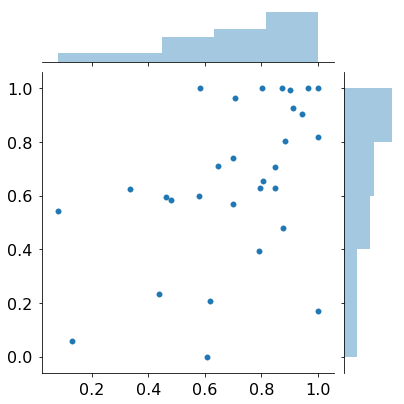

In [13]:
sns.set_context('paper',font_scale = 2)
a1 = results.loc[('NoRT','NoBayes','scan_ctrl'),'alpha'].values
a2 = results.loc[('NoRT','NoBayes','scan_mem'),'alpha'].values
print scipy.stats.pearsonr(a1,a2)
diff_ctrl = abs(a1 - a2)
sns.jointplot(a1, a2, stat_func = None)

plt.savefig('./std_corr.svg', dpi = 300)

In [16]:
%reload_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')
%R require(ggplot2); require(tidyr); require(BayesianFirstAid)

array([1], dtype=int32)

In [13]:
df = pd.DataFrame({'A1_std':results.loc[('NoRT','NoBayes','scan_ctrl'),'alpha'].values,
                   'A2_std':results.loc[('NoRT','NoBayes','scan_mem'),'alpha'].values,
                  'A1_RT':results.loc[('RT','NoBayes','scan_ctrl'),'alpha'].values,
                  'A2_RT':results.loc[('RT','NoBayes','scan_mem'),'alpha'].values})

In [14]:
%%R -i df

fit_std <- bayes.cor.test( ~ A1_std + A2_std, data = df)
std_mcmc <- as.data.frame(fit_std)

fit_RT <- bayes.cor.test( ~ A1_RT + A2_RT, data = df)
RT_mcmc <- as.data.frame(fit_RT)

mean(RT_mcmc$rho - std_mcmc$rho > 0)

  |**************************************************| 100%
  |**************************************************| 100%
[1] 0.9454


In [14]:
df = pd.DataFrame({'A1_std':results.loc[('NoRT','NoBayes','scan_ctrl'),'alpha'].values,
                   'A2_std':results.loc[('NoRT','NoBayes','scan_mem'),'alpha'].values,
                  'A1_RT':results.loc[('NoRT','Bayes','scan_ctrl'),'alpha'].values,
                  'A2_RT':results.loc[('NoRT','Bayes','scan_mem'),'alpha'].values})

In [17]:
%%R -i df

fit_std <- bayes.cor.test( ~ A1_std + A2_std, data = df)
std_mcmc <- as.data.frame(fit_std)

fit_RT <- bayes.cor.test( ~ A1_RT + A2_RT, data = df)
RT_mcmc <- as.data.frame(fit_RT)

mean(RT_mcmc$rho - std_mcmc$rho > 0)

  |**************************************************| 100%
  |**************************************************| 100%
[1] 0.7374


(0.59334464120702046, 0.0005483761688178584)


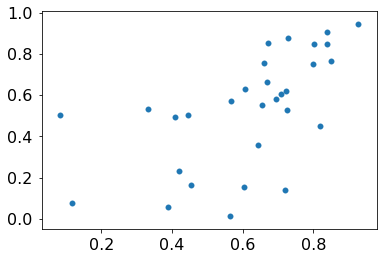

In [22]:
a1 = results.loc[('NoRT','Bayes','scan_ctrl'),'alpha'].values
a2 = results.loc[('NoRT','Bayes','scan_mem'),'alpha'].values

print scipy.stats.pearsonr(a1,a2)
plt.scatter(a1,a2)

In [18]:
a1 = results.loc[('RT','Bayes','scan_ctrl'),'alpha'].values
a2 = results.loc[('RT','Bayes','scan_mem'),'alpha'].values

print scipy.stats.pearsonr(a1,a2)
# plt.scatter(a1,a2)


(0.6034708763829969, 0.00041497236580488448)


(0.74541936205804959, 2.2871877236295241e-06)


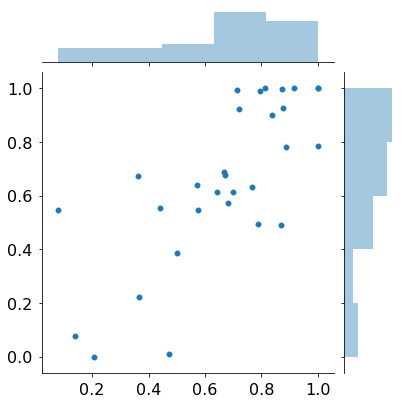

In [29]:
a1 = results.loc[('RT','NoBayes','scan_ctrl'),'alpha'].values
a2 = results.loc[('RT','NoBayes','scan_mem'),'alpha'].values

print scipy.stats.pearsonr(a1,a2)
diff_rt = abs(a1 - a2)
sns.jointplot(a1, a2, stat_func = None, )
plt.savefig('./RT_corr.svg', dpi = 300)

In [89]:
#load behavioral correlate
fname = 'jneuro14_inddiff.mat'
mem = scipy.io.loadmat(data_dir + '/' + fname)

summary_data = {'sub':[],'mem':[],'session':[]}
ids = ['jneuro14_memcorr','jneuro14_behmemcorr']
codes = ['scan_mem','behav_mem']

for index,code in zip(ids, codes):
    nsubs = mem[index].shape[0]
    for i in range(nsubs):
        summary_data['sub'].append(int(i))
        summary_data['mem'].append(float(mem[index][i][0]))
        summary_data['session'].append(code)
summary_data = pd.DataFrame(summary_data)

In [90]:
mem = results.reset_index()
mem = mem[mem['session'] != 'scan_ctrl'].reset_index()
mem = pd.merge(summary_data,
        mem,
        how = 'left',
        on = ['sub','session'])
mem = mem.dropna()
mem = mem.set_index(['rt','bayes'])


In [91]:
a = mem.loc[('NoRT','NoBayes'),'alpha'].values
m = mem.loc[('NoRT','NoBayes'),'mem'].values
# print len(a)
print scipy.stats.pearsonr(a,m)
# plt.scatter(a,m)

(-0.25218606474709054, 0.06078522613025962)


In [92]:
a = mem.loc[('RT','NoBayes'),'alpha'].values
m = mem.loc[('RT','NoBayes'),'mem'].values
scipy.stats.pearsonr(a,m)
# plt.scatter(a,m)

(-0.08416286916473277, 0.53742746246611195)

In [93]:
a = mem.loc[('NoRT','Bayes'),'alpha'].values
m = mem.loc[('NoRT','Bayes'),'mem'].values
scipy.stats.pearsonr(a,m)
# plt.scatter(a,m)

(-0.29855561724645097, 0.02541479217660873)

In [94]:
a = mem.loc[('RT','Bayes'),'alpha'].values
m = mem.loc[('RT','Bayes'),'mem'].values
print scipy.stats.pearsonr(a,m)
# plt.scatter(a,m)

(-0.30400351060217429, 0.022735605063414641)


In [95]:
a1 = mem.loc[('NoRT','NoBayes'),'alpha'].values
m1 = mem.loc[('NoRT','NoBayes'),'m'].values
print 'ctrl',scipy.stats.pearsonr(a1,m1)

a1 = mem.loc[('NoRT','Bayes'),'alpha'].values
m1 = mem.loc[('NoRT','Bayes'),'m'].values
print scipy.stats.pearsonr(a1,m1)


a1 = mem.loc[('RT','NoBayes'),'alpha'].values
m1 = mem.loc[('RT','NoBayes'),'m'].values
print scipy.stats.pearsonr(a1,m1)


a1 = mem.loc[('RT','Bayes'),'alpha'].values
m1 = mem.loc[('RT','Bayes'),'m'].values
print scipy.stats.pearsonr(a1,m1)


ctrl (-0.67997982898569342, 8.2343347835698624e-09)
(-0.46809713571067124, 0.00027475016329390594)
(-0.63017643383321675, 1.9470140688603128e-07)
(-0.47552531469144349, 0.00021243828212588926)


In [96]:
a1.shape

(56,)

In [27]:
df = pd.DataFrame({'A1_std': mem.loc[('NoRT','NoBayes'),'alpha'].values,
                   'A2_std': mem.loc[('NoRT','NoBayes'),'m'].values,
                  'A1_RT': mem.loc[('NoRT','Bayes'),'alpha'].values,
                  'A2_RT': mem.loc[('NoRT','Bayes'),'m'].values})

In [28]:
%%R -i df

fit_std <- bayes.cor.test( ~ A1_std + A2_std, data = df)
std_mcmc <- as.data.frame(fit_std)

fit_RT <- bayes.cor.test( ~ A1_RT + A2_RT, data = df)
RT_mcmc <- as.data.frame(fit_RT)

mean(RT_mcmc$rho - std_mcmc$rho < 0)

  |**************************************************| 100%
  |**************************************************| 100%
[1] 0.366
